## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-8, drp_ratio=0.2):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        x = keras.layers.Dense(units=n_units, 
                               activation="relu", 
                               name="hidden_layer"+str(i+1),
                               kernel_regularizer=l1_l2(l1_l2_ratio))(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-4
EPOCHS = 80
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./saved_models/tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=False,
                             save_weights_only=True)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
keras.backend.clear_session() # 把舊的 Graph 清掉

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

#model = keras.models.load_model("./saved_models/tmp.h5")
#loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
model.load_weights("saved_models/tmp.h5")
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)              

Epoch 45/80
49/49 [==============================] - 1s 22ms/step - loss: 1.6312 - accuracy: 0.6990 - val_loss: 2.0493 - val_accuracy: 0.5584
Epoch 46/80
49/49 [==============================] - 1s 22ms/step - loss: 1.5814 - accuracy: 0.7067 - val_loss: 2.0175 - val_accuracy: 0.5609
Epoch 47/80
49/49 [==============================] - 1s 22ms/step - loss: 1.5567 - accuracy: 0.7053 - val_loss: 2.0114 - val_accuracy: 0.5581
Epoch 48/80
49/49 [==============================] - 1s 22ms/step - loss: 1.5176 - accuracy: 0.7136 - val_loss: 2.0009 - val_accuracy: 0.5586
Epoch 49/80
49/49 [==============================] - 1s 22ms/step - loss: 1.4859 - accuracy: 0.7175 - val_loss: 1.9477 - val_accuracy: 0.5646
Epoch 50/80
49/49 [==============================] - 1s 22ms/step - loss: 1.4506 - accuracy: 0.7214 - val_loss: 1.9435 - val_accuracy: 0.5622
Epoch 51/80
49/49 [==============================] - 1s 22ms/step - loss: 1.4199 - accuracy: 0.7290 - val_loss: 1.9223 - val_accuracy: 0.5585
Epoch 

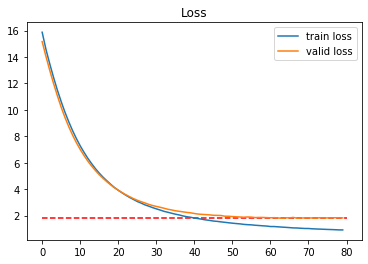

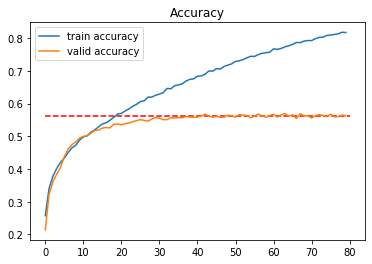

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()